In [9]:
with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())

2024-01-15 19:50:58
available_memory: 24.803668975830078 GB
used_memory: 7.051856994628906 GB


In [10]:
class CustomDataset2(Dataset):  
    def __init__(self, root_dir, transform=None):  
        self.root_dir = root_dir  
        self.classes = sorted(os.listdir(root_dir))  
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}  
        self.samples = self._make_dataset()  
        self.transform = transforms.Compose([  
            transforms.Resize((224, 224)),  # 224x224  
            transforms.ToTensor()  # to tensor
        ])   
  
    def _make_dataset(self):  
        samples = []  
        for class_name in self.classes:  
            class_dir = os.path.join(self.root_dir, class_name)  
            if not os.path.isdir(class_dir):  
                continue  
            for file_name in os.listdir(class_dir):  
                file_path = os.path.join(class_dir, file_name)  
                samples.append((file_path, self.class_to_idx[class_name]))  
        return samples  
  
    def __len__(self):  
        return len(self.samples)  
  
    def __getitem__(self, idx):  
        file_path, label = self.samples[idx]  
        image = torch.load(file_path)  
        return image, label  

class Dataset_ResNet_2(Dataset):  
    def __init__(self,data,label):
        self.Data = torch.from_numpy(np.float32(np.array(data)))
        new_tensor = torch.zeros(self.Data.size(0), 3*224*224)
        new_tensor[:, :self.Data.size(1)] = self.Data
        self.Data = new_tensor
        self.Data = self.Data.view(self.Data.size(0), 3, 224, 224)
        self.Label = torch.from_numpy(np.int64(np.array(label)).reshape(1,-1)[0])
    def __getitem__(self, index):
        x = self.Data[index]
        y = self.Label[index]
        return x, y  
    def __len__(self):
        return len(self.Data)
        
class PscResNet2(nn.Module):
    def __init__(self, dropout_ratio1=0.1, dropout_ratio2=0.1, dropout_ratio3=0.1, num_types=None):
        super(PscResNet2, self).__init__()
        self.dropout_layer1 = nn.Dropout(dropout_ratio1)
        self.resnet18 = torchvision.models.resnet18(weights=None)   
        self.pscMLP = nn.Sequential(
                        nn.ReLU(),
                        nn.Dropout(dropout_ratio2),
                        nn.Linear(1000, 512),
                        nn.ReLU(),
                        nn.Dropout(dropout_ratio3),
                        nn.Linear(512, num_types),
        )
        
    def forward(self, x):
        x = self.dropout_layer1(x)
        x = self.resnet18(x)
        x = self.pscMLP(x)
        return x

class Dataset_ResNet(Dataset):  
    def __init__(self,data,label):
        self.Data = torch.from_numpy(np.float32(np.array(data)))
        self.Data = torch.reshape(self.Data, (data.shape[0], 224, 224))
        self.Data = torch.unsqueeze(self.Data, 1)
        self.Data = torch.cat((self.Data, self.Data, self.Data), dim=1)
        self.Label = torch.from_numpy(np.int64(np.array(label)).reshape(1,-1)[0])
    def __getitem__(self, index):
        x = self.Data[index]
        y = self.Label[index]
        return x, y  
    def __len__(self):
        return len(self.Data)

class PscResNet(nn.Module):
    def __init__(self, dropout_ratio1=0.3, dropout_ratio2=0.1, dropout_ratio3=0.1, num_types=None):
        super(PscResNet, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=False)   
        self.pscMLP = nn.Sequential(
                        nn.ReLU(),
                        nn.Dropout(dropout_ratio1),
                        nn.Linear(1000, num_types))
        
    def forward(self, x):
        x = self.resnet18(x)
        x = self.pscMLP(x)
        return x

class Dataset_MLP(Dataset):  
    def __init__(self,data,label):
        self.Data = torch.from_numpy(np.float32(np.array(data)))
        self.Label = torch.from_numpy(np.int64(np.array(label)).reshape(1,-1)[0])
    def __getitem__(self, index):
        x = self.Data[index]
        y = self.Label[index]
        return x, y  
    def __len__(self):
        return len(self.Data)

class PscMLP(nn.Module):
    def __init__(self, feature_len=None, dropout_ratio1=0.1, dropout_ratio2=0.1, dropout_ratio3=0.1, num_classes=None):
        super().__init__() 
        self.pscMLP = nn.Sequential(nn.Flatten(),
                               nn.Dropout(dropout_ratio1),
                               nn.Linear( feature_len, feature_len//4 ),
                               nn.ReLU(),
                               nn.Dropout(dropout_ratio2),
                               nn.Linear( feature_len//4, feature_len//16 ),
                               nn.ReLU(),
                               nn.Dropout(dropout_ratio3),
                               nn.Linear(feature_len//16, num_classes))
        
    def forward(self, x):
        x = self.pscMLP(x)
        return x

class Dataset_transformer(Dataset):  
    def __init__(self,data,label):
        self.Data = torch.from_numpy(np.float32(np.array(data)))
        self.Data = torch.reshape(self.Data, (data.shape[0], 2, 1024))
        self.Label = torch.from_numpy(np.int64(np.array(label)).reshape(1,-1)[0])
    def __getitem__(self, index):
        x = self.Data[index]
        y = self.Label[index]
        return x, y  
    def __len__(self):
        return len(self.Data)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class CIForm(nn.Module):
    def __init__(self, input_dim, nhead=2, d_model=80, num_classes=2, dropout=0.1):
        super().__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, dim_feedforward=1024, nhead=nhead, dropout=dropout
        )
        self.positionalEncoding = PositionalEncoding(d_model=d_model, dropout=dropout)
        self.pred_layer = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        out = x.permute(1, 0, 2)
        out = self.positionalEncoding(out)
        out = self.encoder_layer(out)
        out = out.transpose(0, 1)
        out = out.mean(dim=1)
        out = self.pred_layer(out)
        return out

In [11]:
def same_seeds(seed=None):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def print_memory_used():
    process = psutil.Process()  
    memory_usage = process.memory_info().rss / 1024 / 1024 /1024 
    print(f"memory used: {memory_usage} GB")  

def print_anndata(input_adata=None):
    new_anndata = input_adata
    print(new_anndata)
    print(new_anndata.obs_names)
    print(new_anndata.var_names)
    print(new_anndata.X.max())
    print(new_anndata.obs)
    print(new_anndata.var)

def preprocessing(input_adata=None,if_filter_genes=True,if_norm=True,if_hvg=False,n_top_hvgs=None):
    new_anndata = input_adata
    if if_filter_genes==True:
        sc.pp.filter_genes(new_anndata, min_cells=1)
        print('Genes filtered.')
    if if_norm==True:
        if new_anndata.X.max() > 50:
            sc.pp.normalize_total(new_anndata, target_sum=1e4)
            sc.pp.log1p(new_anndata)
            print('Data normalized.')
    new_anndata.var_names_make_unique()
    new_anndata.obs_names_make_unique()
    print('Names are changed to be unique.')
    if if_hvg==True:
        if n_top_hvgs is not None:
            sc.pp.highly_variable_genes(new_anndata,n_top_genes=2048)
        else:
            sc.pp.highly_variable_genes(new_anndata)
        sc.pl.highly_variable_genes(new_anndata)
        new_anndata = new_anndata[:, new_anndata.var.highly_variable]
        print('Hvgs selected.')
    return new_anndata

def split_anndata_by_celltype_to_train_valid_test(new_anndata=None, celltype_label='celltype', split_ratio=[0.8,0.1,0.1], random_seed=42):  
    # split adata to three part by given ratio
    np.random.seed(random_seed)
    train_anndata = None
    valid_anndata = None
    test_anndata = None
    
    for celltype in new_anndata.obs[celltype_label].unique(): 
        celltype_indices = new_anndata.obs[celltype_label] == celltype  
        celltype_data = new_anndata[celltype_indices]  
        
        total_cells = len(celltype_data)  
        x, y, z = split_ratio  
        x_count = int(total_cells * x / (x + y + z))  
        y_count = int(total_cells * y / (x + y + z))  
        z_count = total_cells - x_count - y_count  
        
        indices = np.random.permutation(total_cells)  
        train_indices = indices[:x_count]  
        valid_indices = indices[x_count:x_count + y_count]  
        test_indices = indices[x_count + y_count:]  
        
        train_data = celltype_data[train_indices]  
        valid_data = celltype_data[valid_indices]  
        test_data = celltype_data[test_indices]  
        
        if train_anndata is None:
            train_anndata = train_data
        else:
            train_anndata = train_anndata.concatenate(train_data, index_unique=None)  
        if valid_anndata is None:
            valid_anndata = valid_data
        else:
            valid_anndata = valid_anndata.concatenate(valid_data, index_unique=None)   
        if test_anndata is None:
            test_anndata = test_data
        else:
            test_anndata = test_anndata.concatenate(test_data, index_unique=None)   
        
    return train_anndata, valid_anndata, test_anndata

def generate_datas_and_labels(input_adatas=None, the_length=None, if_balance_train_data=None, random_sample_num=None):
    new_anndata_train = input_adatas[0]
    new_anndata_valid = input_adatas[1]
    new_anndata_test = input_adatas[2]
    pcma = PCmaster_anno_0()
    train_data,mapping_1,mapping_2 = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_train, the_length=the_length)
    valid_data,_,_ = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_valid, the_length=the_length)
    test_data,_,_ = pcma.auto_annotation_with_deep_learning_transfer_adata_to_df_for_all_0(
        adata_input = new_anndata_test, the_length=the_length)
    
    # displays the number of categories and the number of each category.
    category_counts = train_data['celltype'].value_counts()
    print("the number of categories: ", len(category_counts))
    print("the number of each category: ")
    print(category_counts)
    print(mapping_1)
    print(mapping_2)
    
    if if_balance_train_data is True:
        train_data_balanced = pd.DataFrame()
        for category in category_counts.index:
            category_data = train_data[train_data['celltype'] == category]
            print(category)
            print(category_data.shape[0])
            # print(type(category_data.shape[0]))
            category_data = category_data.sample(n=random_sample_num, random_state=1, replace=True)
            train_data_balanced = pd.concat([train_data_balanced, category_data])
        train_data = train_data_balanced
    
    print_memory_used() 
    
    train_label = train_data.iloc[:, -1:]
    train_data = train_data.iloc[:, :-2]
    valid_label = valid_data.iloc[:, -1:]
    valid_data = valid_data.iloc[:, :-2]
    test_label = test_data.iloc[:, -1:]
    test_data = test_data.iloc[:, :-2]
    
    return train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts

# GPU
def evaluate_accuracy_gpu(net, data_iter, device=None): 
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# GPU
def train_with_GPU(net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    if optimizer == 'SGD':
        if momentum is not None:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        else:
            optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    if optimizer == 'Adam':
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150, eta_min=0.00001)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],ylim=[0,1],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    best_model_weights = None
    best_valid_acc = 0.0
    best_epoch = 0
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        valid_acc = evaluate_accuracy_gpu(net, valid_iter)
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            best_epoch = epoch
            best_model_weights = net.state_dict()
        animator.add(epoch + 1, (None, None, valid_acc))
    net.load_state_dict(best_model_weights)
    print(f'At the epoch {best_epoch}, the model got the best valid accuracy {best_valid_acc}.')
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {valid_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [12]:
def get_accuracy_precision_recall_f1_score(test_label=None,predicted=None):
    accuracy = accuracy_score(test_label, predicted)  
    # macro precision 
    macro_precision = precision_score(test_label, predicted, average='macro', zero_division=1)  
    
    # macro recall  
    macro_recall = recall_score(test_label, predicted, average='macro', zero_division=1)  
    
    # macro F1 score
    macro_f1_score = f1_score(test_label, predicted, average='macro', zero_division=1)  
    
    print("Accuracy:", accuracy)  
    print("Macro Precision:", macro_precision)  
    print("Macro Recall:", macro_recall)  
    print("Macro F1 Score:", macro_f1_score)
    
    return accuracy, macro_precision, macro_recall, macro_f1_score

def train_ResNet2(
    train_data=None,train_label=None,valid_data=None,valid_label=None,test_data=None,test_label=None,
    the_batch_size=None,num_classes=None,lr=None,dropout_ratio1=None,dropout_ratio2=None,dropout_ratio3=None,
    epochs=None,gpu_code=None,the_num_workers=None,optimizer=None, momentum=None,
):
    
    traindata = Dataset_ResNet_2(train_data,train_label) 
    validdata = Dataset_ResNet_2(valid_data,valid_label)
    
    train_sampler = RandomSampler(traindata)
    train_iter = DataLoader(traindata,batch_size=the_batch_size,shuffle=False,sampler=train_sampler,
                            num_workers=the_num_workers)
    valid_sampler = RandomSampler(validdata)
    valid_iter = DataLoader(validdata,batch_size=the_batch_size,shuffle=False,sampler=valid_sampler,
                            num_workers=the_num_workers)
    
    del train_data,train_label,valid_data,valid_label,traindata,validdata
    gc.collect()
    print_memory_used()
    print(f'num_classes = {num_classes}')
    
    pscresnet = PscResNet2(
        dropout_ratio1=dropout_ratio1, dropout_ratio2=dropout_ratio2, dropout_ratio3=dropout_ratio3, num_types=num_classes,
    )
    
    torch.cuda.init()
    # net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None
    train_with_GPU(net=pscresnet, train_iter=train_iter, valid_iter=valid_iter, 
                   num_epochs=epochs, lr=lr, device=d2l.try_all_gpus()[gpu_code], optimizer=optimizer, momentum=momentum)
    model = pscresnet
    del train_sampler,train_iter,valid_sampler,valid_iter
    gc.collect()
    print_memory_used()
    
    import math
    
    batch_size = 32 
    total_size = test_data.shape[0]
    total_batches = math.ceil(total_size / batch_size)
    
    net_try = model
    net_try = net_try.to('cpu')
    net_try.eval()
    
    with torch.no_grad():
        predicted_results = []
        for i in range(total_batches):
            start = i * batch_size
            end = min(start + batch_size, total_size)
            batch_data = test_data[start:end]
            batch_label = test_label[start:end]
            batch_data = torch.from_numpy(np.float32(np.array(batch_data)))
            new_tensor = torch.zeros(batch_data.size(0), 3*224*224)
            new_tensor[:, :batch_data.size(1)] = batch_data
            batch_data = new_tensor
            batch_data = batch_data.view(batch_data.size(0), 3, 224, 224)
            batch_label = torch.from_numpy(np.int64(np.array(batch_label)).reshape(1,-1)[0])
            outputs = net_try(batch_data)
            _, predicted = torch.max(outputs, 1)
            predicted_results.append(predicted.numpy())
            
    predicted = np.concatenate(predicted_results)
    test_label = torch.from_numpy(np.int64(np.array(test_label)).reshape(1,-1)[0])
    test_label = test_label.numpy()
    
    accuracy,macro_precision,macro_recall,macro_f1_score = get_accuracy_precision_recall_f1_score(
        test_label=test_label,predicted=predicted)

    return model, accuracy, macro_precision, macro_recall, macro_f1_score

def train_ResNet(
    train_data=None,train_label=None,valid_data=None,valid_label=None,test_data=None,test_label=None,
    the_batch_size=None,num_classes=None,lr=None,dropout_ratio1=None,dropout_ratio2=None,dropout_ratio3=None,
    epochs=None,gpu_code=None,the_num_workers=None,optimizer=None, momentum=None,
):
    
    traindata = Dataset_ResNet(train_data,train_label) 
    validdata = Dataset_ResNet(valid_data,valid_label)
    
    train_sampler = RandomSampler(traindata)
    train_iter = DataLoader(traindata,batch_size=the_batch_size,shuffle=False,sampler=train_sampler,
                            num_workers=the_num_workers)
    valid_sampler = RandomSampler(validdata)
    valid_iter = DataLoader(validdata,batch_size=the_batch_size,shuffle=False,sampler=valid_sampler,
                            num_workers=the_num_workers)
    
    del train_data,train_label,valid_data,valid_label,traindata,validdata
    gc.collect()
    print_memory_used()
    print(f'num_classes = {num_classes}')
    
    pscresnet = PscResNet(
        dropout_ratio1=dropout_ratio1, dropout_ratio2=dropout_ratio2, dropout_ratio3=dropout_ratio3, num_types=num_classes,
    )
    pretrained_dict = torch.load('resnet18.pth')
    model_dict = pscresnet.resnet18.state_dict()
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    pscresnet.resnet18.load_state_dict(model_dict)
    torch.cuda.init()
    
    # net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None
    train_with_GPU(net=pscresnet, train_iter=train_iter, valid_iter=valid_iter, 
                   num_epochs=epochs, lr=lr, device=d2l.try_all_gpus()[gpu_code], optimizer=optimizer, momentum=momentum)
    model = pscresnet
    del train_sampler,train_iter,valid_sampler,valid_iter
    gc.collect()
    print_memory_used()
    
    import math
    
    batch_size = 32 
    total_size = test_data.shape[0]
    total_batches = math.ceil(total_size / batch_size)
    
    net_try = model
    net_try = net_try.to('cpu')
    net_try.eval()
    
    with torch.no_grad():
        predicted_results = []
        for i in range(total_batches):
            start = i * batch_size
            end = min(start + batch_size, total_size)
            batch_data = test_data[start:end]
            batch_label = test_label[start:end]
            batch_data = torch.from_numpy(np.float32(np.array(batch_data)))
            batch_data = torch.reshape(batch_data, (batch_data.shape[0], 224, 224))
            batch_data = torch.unsqueeze(batch_data, 1)
            batch_data = torch.cat((batch_data, batch_data, batch_data), dim=1)
            batch_label = torch.from_numpy(np.int64(np.array(batch_label)).reshape(1,-1)[0])
            outputs = net_try(batch_data)
            _, predicted = torch.max(outputs, 1)
            predicted_results.append(predicted.numpy())
            
    predicted = np.concatenate(predicted_results)
    test_label = torch.from_numpy(np.int64(np.array(test_label)).reshape(1,-1)[0])
    test_label = test_label.numpy()
    
    accuracy,macro_precision,macro_recall,macro_f1_score = get_accuracy_precision_recall_f1_score(
        test_label=test_label,predicted=predicted)

    return model, accuracy, macro_precision, macro_recall, macro_f1_score

def train_SVM(
    train_data=None,train_label=None,valid_data=None,valid_label=None,test_data=None,test_label=None,
):
    Classifier = LinearSVC()
    clf = CalibratedClassifierCV(Classifier)
    start_time = time.time()
    clf.fit(train_data, train_label)
    model = clf
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"time cost：{execution_time} s")
    start_time = time.time()
    
    predicted = clf.predict(test_data)
    
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"time cost：{execution_time} s")
    
    accuracy,macro_precision,macro_recall,macro_f1_score = get_accuracy_precision_recall_f1_score(
        test_label=test_label,predicted=predicted)
    
    return model, accuracy, macro_precision, macro_recall, macro_f1_score

def train_MLP(
    train_data=None,train_label=None,valid_data=None,valid_label=None,test_data=None,test_label=None,
    the_batch_size=None,num_classes=None,lr=None,dropout_ratio1=None,dropout_ratio2=None,dropout_ratio3=None,feature_len=None,
    epochs=None,gpu_code=None,the_num_workers=None,optimizer=None, momentum=None,
):
    
    traindata = Dataset_MLP(train_data,train_label) 
    validdata = Dataset_MLP(valid_data,valid_label)
    
    train_sampler = RandomSampler(traindata)
    train_iter = DataLoader(traindata,batch_size=the_batch_size,shuffle=False,sampler=train_sampler,
                            num_workers=the_num_workers)
    valid_sampler = RandomSampler(validdata)
    valid_iter = DataLoader(validdata,batch_size=the_batch_size,shuffle=False,sampler=valid_sampler,
                            num_workers=the_num_workers)
    
    del train_data,train_label,valid_data,valid_label,traindata,validdata
    gc.collect()
    print_memory_used()
    print(f'num_classes = {num_classes}')
    
    pscmlp = PscMLP(
        feature_len=feature_len,
        dropout_ratio1=dropout_ratio1, dropout_ratio2=dropout_ratio2, dropout_ratio3=dropout_ratio3, 
        num_classes=num_classes,
    )
    
    torch.cuda.init()
    # net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None
    train_with_GPU(net=pscmlp, train_iter=train_iter, valid_iter=valid_iter, 
                   num_epochs=epochs, lr=lr, device=d2l.try_all_gpus()[gpu_code], optimizer=optimizer, momentum=momentum)
    model = pscmlp
    del train_sampler,train_iter,valid_sampler,valid_iter
    gc.collect()
    print_memory_used()
    
    import math
    
    batch_size = 32 
    total_size = test_data.shape[0]
    total_batches = math.ceil(total_size / batch_size)
    
    net_try = model
    net_try = net_try.to('cpu')
    net_try.eval()
    
    with torch.no_grad():
        predicted_results = []
        for i in range(total_batches):
            start = i * batch_size
            end = min(start + batch_size, total_size)
            batch_data = test_data[start:end]
            batch_label = test_label[start:end]
            batch_data = torch.from_numpy(np.float32(np.array(batch_data)))
            batch_label = torch.from_numpy(np.int64(np.array(batch_label)).reshape(1,-1)[0])
            outputs = net_try(batch_data)
            _, predicted = torch.max(outputs, 1)
            predicted_results.append(predicted.numpy())
            
    predicted = np.concatenate(predicted_results)
    test_label = torch.from_numpy(np.int64(np.array(test_label)).reshape(1,-1)[0])
    test_label = test_label.numpy()
    
    accuracy,macro_precision,macro_recall,macro_f1_score = get_accuracy_precision_recall_f1_score(
        test_label=test_label,predicted=predicted)

    return model, accuracy, macro_precision, macro_recall, macro_f1_score

def train_CIForm(
    train_data=None,train_label=None,valid_data=None,valid_label=None,test_data=None,test_label=None,
    the_batch_size=None,num_classes=None,lr=None,dropout_ratio1=None,dropout_ratio2=None,dropout_ratio3=None,feature_len=None,
    epochs=None,gpu_code=None,the_num_workers=None,the_num_heads=None,optimizer=None, momentum=None,
):
    traindata = Dataset_transformer(train_data,train_label) 
    validdata = Dataset_transformer(valid_data,valid_label)
    
    train_sampler = RandomSampler(traindata)
    train_iter = DataLoader(traindata,batch_size=the_batch_size,shuffle=False,sampler=train_sampler,
                            num_workers=the_num_workers)
    valid_sampler = RandomSampler(validdata)
    valid_iter = DataLoader(validdata,batch_size=the_batch_size,shuffle=False,sampler=valid_sampler,
                            num_workers=the_num_workers)
    del traindata,train_data,train_label,validdata,valid_data,valid_label
    gc.collect() 
    print_memory_used()
    
    s = feature_len//2
    heads = the_num_heads
    dp = dropout_ratio1
    batch_sizes = the_batch_size
    num_classes = num_classes
    print(f'num_classes = {num_classes}')
    
    ciform = CIForm(input_dim=s, nhead=heads, d_model=s,
                       num_classes=num_classes,dropout=dp)
    
    torch.cuda.init()
    # net=None, train_iter=None, valid_iter=None, num_epochs=None, lr=None, device=None, optimizer='Adam', momentum=None
    train_with_GPU(net=ciform, train_iter=train_iter, valid_iter=valid_iter, 
                   num_epochs=epochs, lr=lr, device=d2l.try_all_gpus()[gpu_code], optimizer=optimizer, momentum=momentum)
    model = ciform
    del train_sampler,train_iter,valid_sampler,valid_iter
    gc.collect()
    print_memory_used()
    
    import math
    
    batch_size = 32 
    total_size = test_data.shape[0]
    total_batches = math.ceil(total_size / batch_size)
    
    net_try = model
    net_try = net_try.to('cpu')
    net_try.eval()
    
    with torch.no_grad():
        predicted_results = []
        for i in range(total_batches):
            start = i * batch_size
            end = min(start + batch_size, total_size)
            batch_data = test_data[start:end]
            batch_label = test_label[start:end]
            batch_data = torch.from_numpy(np.float32(np.array(batch_data)))
            batch_data = torch.reshape(batch_data, (batch_data.shape[0], 2, 1024))
            batch_label = torch.from_numpy(np.int64(np.array(batch_label)).reshape(1,-1)[0])
            outputs = net_try(batch_data)
            _, predicted = torch.max(outputs, 1)
            predicted_results.append(predicted.numpy())
    predicted = np.concatenate(predicted_results)
    test_label = torch.from_numpy(np.int64(np.array(test_label)).reshape(1,-1)[0])
    test_label = test_label.numpy()
    testlabel = test_label
    
    accuracy,macro_precision,macro_recall,macro_f1_score = get_accuracy_precision_recall_f1_score(
        test_label=test_label,predicted=predicted)
    
    return model, accuracy, macro_precision, macro_recall, macro_f1_score

def train_union():
    return 0

At the epoch 16, the model got the best valid accuracy 0.9629629629629629.
loss 0.010, train acc 0.997, valid acc 0.951
17328.2 examples/sec on cuda:0
memory used: 2.8283348083496094 GB
Accuracy: 0.9672447013487476
Macro Precision: 0.955835025189864
Macro Recall: 0.9820664869721474
Macro F1 Score: 0.9680721635347777


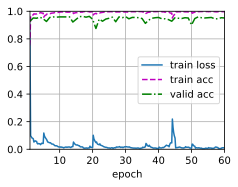

In [13]:
# CIForm

with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())

renames = []
renumofcells = []
renumofcelltypes = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_norm=True
if_hvg=True
n_top_hvgs=2048
celltype_label = 'Celltype'
split_ratio=[0.8,0.1,0.1]
if_df = True
if_feature_len = True
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256
lr=0.0004
dropout_ratio1=0.1
dropout_ratio2=0.1 # not use
dropout_ratio3=0.1 # not use
epochs=60
gpu_code=0
the_num_workers=0
the_num_heads=64 # for CIForm
the_optimizer='Adam'
the_momentum=None

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=if_norm,if_hvg=if_hvg,n_top_hvgs=n_top_hvgs)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = int(math.sqrt(feature_len) + 1),
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True:
            train_data = train_data.iloc[:,:feature_len]
            valid_data = valid_data.iloc[:,:feature_len]
            test_data = test_data.iloc[:,:feature_len]
            
        model, accuracy, macro_precision, macro_recall, macro_f1_score = train_CIForm(
            train_data=train_data,train_label=train_label,
            valid_data=valid_data,valid_label=valid_label,
            test_data=test_data,test_label=test_label,
            the_batch_size=the_batch_size,num_classes=num_classes,
            lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,feature_len=feature_len,
            epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,the_num_heads=the_num_heads,
            optimizer=the_optimizer,momentum=the_momentum,
        )
        
        renames.append(file.replace('.h5ad',''))
        renumofcells.append(numofcells)
        renumofcelltypes.append(numofcelltypes)
        reaccuracys.append(accuracy)
        remacrof1scores.append(macro_f1_score)
        break
    break

In [14]:
# MLP

with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())
    
renames = []
renumofcells = []
renumofcelltypes = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_norm=True
if_hvg=True
n_top_hvgs=None
celltype_label = 'Celltype'
split_ratio=[0.8,0.1,0.1]
if_df = True
if_feature_len = True
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256
lr=0.0004
dropout_ratio1=0.1
dropout_ratio2=0.1
dropout_ratio3=0.1
epochs=20
gpu_code=0
the_num_workers=0
the_optimizer='Adam'
the_momentum=None

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=if_norm,if_hvg=if_hvg,n_top_hvgs=n_top_hvgs)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = int(math.sqrt(feature_len) + 1),
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True:
            train_data = train_data.iloc[:,:feature_len]
            valid_data = valid_data.iloc[:,:feature_len]
            test_data = test_data.iloc[:,:feature_len]
            
        model, accuracy, macro_precision, macro_recall, macro_f1_score = train_MLP(
            train_data=train_data,train_label=train_label,
            valid_data=valid_data,valid_label=valid_label,
            test_data=test_data,test_label=test_label,
            the_batch_size=the_batch_size,num_classes=num_classes,
            lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,feature_len=feature_len,
            epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,
            optimizer=the_optimizer,momentum=the_momentum,
        )
        
        renames.append(file.replace('.h5ad',''))
        renumofcells.append(numofcells)
        renumofcelltypes.append(numofcelltypes)
        reaccuracys.append(accuracy)
        remacrof1scores.append(macro_f1_score)
        break
    break

At the epoch 12, the model got the best valid accuracy 0.9571150097465887.
loss 0.000, train acc 1.000, valid acc 0.955
20664.6 examples/sec on cuda:0
memory used: 3.4027557373046875 GB
Accuracy: 0.9672447013487476
Macro Precision: 0.9596912848624024
Macro Recall: 0.9624724389315118
Macro F1 Score: 0.9607331035272874


In [15]:
# SVM

with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())

renames = []
renumofcells = []
renumofcelltypes = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_norm=True
if_hvg=True
n_top_hvgs=None
celltype_label = 'Celltype'
split_ratio=[0.8,0.1,0.1]
if_df = True
if_feature_len = True
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256 # not use
lr=0.0004          # not use
dropout_ratio1=0.1 # not use
dropout_ratio2=0.1 # not use
dropout_ratio3=0.1 # not use
epochs=10          # not use
gpu_code=0         # not use
the_num_workers=0  # not use

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=if_norm,if_hvg=if_hvg,n_top_hvgs=n_top_hvgs)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = int(math.sqrt(feature_len) + 1),
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True:
            train_data = train_data.iloc[:,:feature_len]
            valid_data = valid_data.iloc[:,:feature_len]
            test_data = test_data.iloc[:,:feature_len]
            
        model, accuracy, macro_precision, macro_recall, macro_f1_score = train_SVM(
            train_data=train_data,train_label=train_label,
            valid_data=valid_data,valid_label=valid_label,
            test_data=test_data,test_label=test_label,
        )
        
        renames.append(file.replace('.h5ad',''))
        renumofcells.append(numofcells)
        renumofcelltypes.append(numofcelltypes)
        reaccuracys.append(accuracy)
        remacrof1scores.append(macro_f1_score)
        break
    break

2024-01-15 19:53:20
available_memory: 22.23773956298828 GB
used_memory: 9.617786407470703 GB
random_seed = 40
Genes filtered.
Data normalized.
Names are changed to be unique.


Hvgs selected.
View of AnnData object with n_obs × n_vars = 5153 × 7476
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    obsm: 'X_tsne', 'X_umap'
Index(['CRX125602@@_AAACCTGGTTCGCGAC-1', 'CRX125602@@_AAAGATGAGCAATCTC-1',
       'CRX125602@@_AAAGATGAGCTCTCGG-1', 'CRX125602@@_AAAGATGTCATCATTC-1',
       'CRX125602@@_AAAGATGTCTGCCCTA-1', 'CRX125602@@_AAAGCAACAATGGATA-1',
       'CRX125602@@_AAAGCAATCAGCTTAG-1', 'CRX125602@@_AAAGTAGAGCGAAGGG-1',
       'CRX125602@@_AAAGTAGCAATGGTCT-1', 'CRX125602@@_AAAGTAGCATGGATGG-1',
       ...
       'CRX125602@@_TTGCCGTTCCACGACG-1', 'CRX125602@@_TTGGAACCAGTTCCCT-1',
       'CRX125602@@_TTTATGCAGCTTATCG-1', 'CRX125602@@_TTTATGCTCCAGAGGA-1',
       'CRX125602@@_TTTATGCTCTCGGACG-1', 'CRX125602@@_TTTATGCTCT

C:\Users\86135\AppData\Local\Temp\ipykernel_12160\3478703615.py:56: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  new_anndata.obs['cellname'] = new_anndata.obs_names
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\anndata\_core\anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site

18860

the number of categories:  7
the number of each category: 
celltype
0    1200
1    1200
2     627
3     415
4     281
5     228
6     170
Name: count, dtype: int64
{'Mesophyll': 0, 'Xylem': 1, 'Leaf pavement cell': 2, 'Leaf guard cell': 3, 'Phloem parenchyma': 4, 'S phase': 5, 'Companion cell': 6}
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
0
1200
1
1200
2
627
3
415
4
281
5
228
6
170
memory used: 4.2693634033203125 GB


1228

D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
D:\aaa-new\setups\conda\conda-files\envs\PCmaster_anno_win\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Libli

time cost：29.794748067855835 s
time cost：0.16884541511535645 s
Accuracy: 0.9672447013487476
Macro Precision: 0.9649736248939805
Macro Recall: 0.9677190025320117
Macro F1 Score: 0.9660996990120977


At the epoch 15, the model got the best valid accuracy 0.9278752436647173.
loss 0.005, train acc 0.998, valid acc 0.914
523.0 examples/sec on cuda:0
memory used: 11.793193817138672 GB
Accuracy: 0.9633911368015414
Macro Precision: 0.9569437043443489
Macro Recall: 0.9688216831909544
Macro F1 Score: 0.9623209918387108


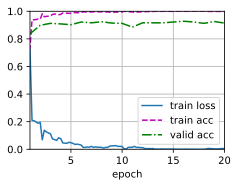

In [17]:
# ResNet

with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())
    
renames = []
renumofcells = []
renumofcelltypes = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_hvg=False
n_top_hvgs=None
celltype_label = 'Celltype'
split_ratio=[0.8,0.1,0.1]
if_df = True
if_feature_len = False # max feature_len is 224*224
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=16
lr=0.01
dropout_ratio1=0.3
dropout_ratio2=0.1 # not use
dropout_ratio3=0.1 # not use
epochs=20
gpu_code=0
the_num_workers=0
the_optimizer='SGD'
the_momentum=0.9
the_length=224 # max feature_len is 224*224

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=True,if_hvg=False,n_top_hvgs=None)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = the_length,
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True:
            train_data = train.iloc[:,:feature_len]
            valid_data = valid.iloc[:,:feature_len]
            test_data = test.iloc[:,:feature_len]
            
        model, accuracy, macro_precision, macro_recall, macro_f1_score = train_ResNet(
            train_data=train_data,train_label=train_label,
            valid_data=valid_data,valid_label=valid_label,
            test_data=test_data,test_label=test_label,
            the_batch_size=the_batch_size,num_classes=num_classes,
            lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,
            epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,
            optimizer=the_optimizer,momentum=the_momentum,
        )
        
        renames.append(file.replace('.h5ad',''))
        renumofcells.append(numofcells)
        renumofcelltypes.append(numofcelltypes)
        reaccuracys.append(accuracy)
        remacrof1scores.append(macro_f1_score)
        break
    break

In [18]:
# ResNet2

with open('PCmaster_anno_0_23_12_24.py','r',encoding='utf-8') as f:
    exec(f.read())
    
renames = []
renumofcells = []
renumofcelltypes = []
reaccuracys = []
remacrof1scores = []
root_dir = 'E:/scplantdb-max-1500-per-cell-type/'
files = os.listdir(root_dir)
filepath_list = None
random_seeds = range(40,56)
if_hvg=False
n_top_hvgs=None
celltype_label = 'Celltype'
split_ratio=[0.8,0.1,0.1]
if_df = True
if_feature_len = False # max feature_len is 3*224*224
if_balance_train_data = True
random_sample_num = 1500
the_batch_size=256
lr=0.0004
dropout_ratio1=0.1
dropout_ratio2=0.1
dropout_ratio3=0.1
epochs=20
gpu_code=0
the_num_workers=0
the_optimizer='Adam'
the_momentum=None

for random_seed in random_seeds:
    print(f'random_seed = {random_seed}')
    same_seeds(seed = random_seed)
    for file in files:
        if not file.endswith('.h5ad'):
            continue
        file_path = root_dir+file
        if filepath_list is not None:
            if file_path not in filepath_list:
                continue
        new_anndata = sc.read(file_path)
        numofcells = len(new_anndata.obs_names)
        new_anndata = preprocessing(input_adata=new_anndata,if_filter_genes=True,
                            if_norm=True,if_hvg=False,n_top_hvgs=None)
        print_anndata(input_adata=new_anndata)
        num_classes = len(new_anndata.obs[celltype_label].value_counts())
        numofcelltypes = num_classes
        
        feature_len = len(new_anndata.var_names)
        print(f'feature_len = {feature_len}')
        
        print_memory_used()
        
        new_anndata.obs['cellname'] = new_anndata.obs_names
        new_anndata.obs['celltype'] = new_anndata.obs[celltype_label]
        new_anndata_train, new_anndata_valid, new_anndata_test = split_anndata_by_celltype_to_train_valid_test(
            new_anndata=new_anndata, celltype_label=celltype_label, split_ratio=split_ratio, random_seed=random_seed,
        )
        del new_anndata
        gc.collect()
        if if_df is True:
            train_data,train_label,valid_data,valid_label,test_data,test_label,mapping_1,mapping_2,category_counts = generate_datas_and_labels(
                input_adatas = [new_anndata_train, new_anndata_valid, new_anndata_test],
                the_length = int(math.sqrt(feature_len) + 1),
                if_balance_train_data = if_balance_train_data,
                random_sample_num = random_sample_num,
            )
            del new_anndata_train, new_anndata_valid, new_anndata_test
            gc.collect()
        if if_feature_len is True:
            train_data = train.iloc[:,:feature_len]
            valid_data = valid.iloc[:,:feature_len]
            test_data = test.iloc[:,:feature_len]
            
        model, accuracy, macro_precision, macro_recall, macro_f1_score = train_ResNet2(
            train_data=train_data,train_label=train_label,
            valid_data=valid_data,valid_label=valid_label,
            test_data=test_data,test_label=test_label,
            the_batch_size=the_batch_size,num_classes=num_classes,
            lr=lr,dropout_ratio1=dropout_ratio1,dropout_ratio2=dropout_ratio2,dropout_ratio3=dropout_ratio3,
            epochs=epochs,gpu_code=gpu_code,the_num_workers=the_num_workers,
            optimizer=the_optimizer,momentum=the_momentum,
        )
        
        renames.append(file.replace('.h5ad',''))
        renumofcells.append(numofcells)
        renumofcelltypes.append(numofcelltypes)
        reaccuracys.append(accuracy)
        remacrof1scores.append(macro_f1_score)
        break
    break

At the epoch 11, the model got the best valid accuracy 0.9239766081871345.
loss 0.106, train acc 0.965, valid acc 0.916
651.7 examples/sec on cuda:0
memory used: 9.972347259521484 GB
Accuracy: 0.9248554913294798
Macro Precision: 0.9293169102812138
Macro Recall: 0.912621371611596
Macro F1 Score: 0.9194407388843853


In [ ]:
# try SGD and different ResNet structure! The optimizer parameter! 
# try the old structure of ResNet.